In [25]:
import sys
from pathlib import Path

from rich.jupyter import display

ROOT = Path().resolve().parent
sys.path.append(str(ROOT))


In [26]:
import pandas as pd
from sklearn.metrics import confusion_matrix

from research.urgency import UrgencyPredictorNLP
from research.scarcity import ScarcityPredictorNLP
urgency_dataset = pd.read_csv("datasets/urgency.csv")


urgency_predictor  = UrgencyPredictorNLP()


# Predict only giving the text column
y_true = urgency_dataset["is_urgency"]
y_pred = urgency_predictor.predict_multiple(urgency_dataset["text"])

confusion_matrix(y_true, y_pred)

array([[11,  0],
       [ 0, 25]], dtype=int64)

In [27]:

scarcity_dataset = pd.read_csv("datasets/scarcity.csv" )
scarcity_predictor = ScarcityPredictorNLP()
y_true = scarcity_dataset["is_scarcity"]
y_pred = scarcity_predictor.predict_multiple(scarcity_dataset["text"])
confusion_matrix(y_true, y_pred)

array([[2, 0],
       [2, 8]], dtype=int64)

In [28]:
# Read from the datasets/images directory, get all the name of files, count scarcity and urgency based on if it's in the name

import os
from collections import Counter

directory_path = "datasets/images"

file_metrics = Counter({'scarcity': 0, 'urgency': 0, 'other': 0})

if os.path.exists(directory_path):
    files = [f.lower() for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    for filename in files:
        if "scarcity" in filename:
            file_metrics['scarcity'] += 1
        elif "urgency" in filename:
            file_metrics['urgency'] += 1
        else :
            file_metrics['other'] += 1
    print(f"Total Files Scanned: {len(files)}")
    print(f"Scarcity Count: {file_metrics['scarcity']}")
    print(f"Urgency Count: {file_metrics['urgency']}")
    print(f"Other Count: {file_metrics['other']}")
else:
    print(f"Error: The directory '{directory_path}' was not found.")

Total Files Scanned: 104
Scarcity Count: 39
Urgency Count: 58
Other Count: 7


In [29]:
import csv
from collections import Counter

counts = Counter()

with open("datasets/unified_dataset.csv", newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        counts[row["type"]] += 1

for k, v in counts.items():
    print(f"{k}: {v}")




fake_urgency: 63
fake_scarcity: 48
ninguno: 4


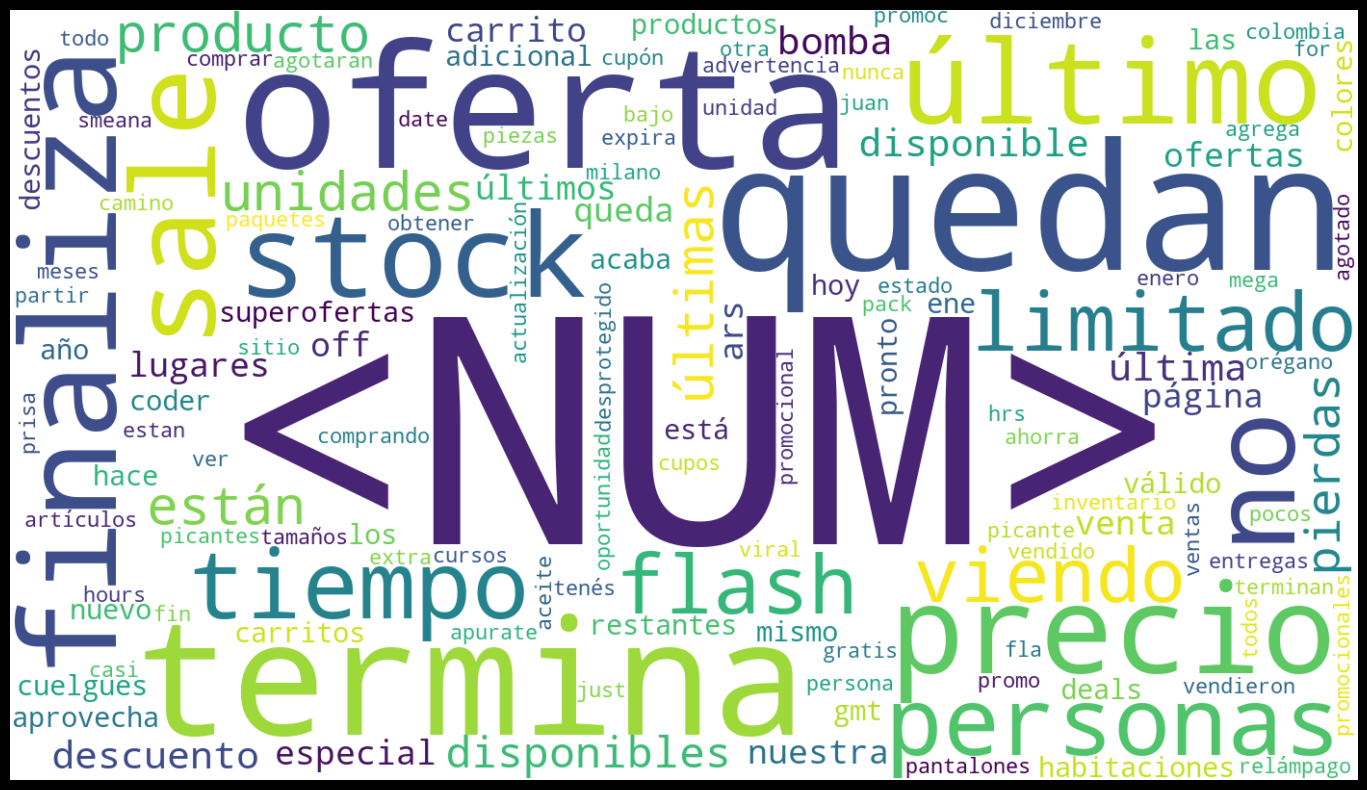

In [30]:
# pip install wordcloud matplotlib

import csv
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

STOPWORDS_ES = {
    "de","la","el","y","a","en","por","para","con","sin","un","una","unos","unas",
    "lo","al","del","que","se","es","este","esta","estos","estas","hay","más","mas",
    "ya","ahora","solo","sólo","muy","tu","tú","su","sus","mi","mis","te","vos","ustedes",
    "desde","hasta","o","u","pero","si","sí","me","le","les","esto","eso","esa","ese",
    "min","mins","seg","segs","hs","hora","horas","minutos","segundos","día","dias","días"
}

def tokenize(text: str):
    text = text.lower()
    # normalizar números/contadores para que no dominen la nube
    text = re.sub(r"\d+([:.,]\d+)*", " <NUM> ", text)  # 03:16:29:07, 11:58:14, 87%, etc
    text = re.sub(r"[^\wáéíóúñü<>]+", " ", text, flags=re.UNICODE)
    tokens = [t for t in text.split() if t not in STOPWORDS_ES and len(t) > 1]
    return tokens

# --- cargar CSV y construir texto ---
tokens = []
with open("datasets/unified_dataset.csv", newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        tokens.extend(tokenize(row["content"]))

freq = Counter(tokens)

# --- nube ---
wc = WordCloud(
    width=1400,
    height=800,
    background_color="white",
    collocations=False,  # evita juntar bigramas raros
    max_words=200
).generate_from_frequencies(freq)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.imshow(wc.to_image(), interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()



=== Classification report ===
               precision    recall  f1-score   support

fake_scarcity      0.889     0.889     0.889         9
 fake_urgency      0.857     0.923     0.889        13
      ninguno      0.000     0.000     0.000         1

     accuracy                          0.870        23
    macro avg      0.582     0.604     0.593        23
 weighted avg      0.832     0.870     0.850        23

=== Confusion matrix ===


C:\Users\frank\OneDrive\Documentos\GitHub\dark-patterns-tesina\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\frank\OneDrive\Documentos\GitHub\dark-patterns-tesina\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\frank\OneDrive\Documentos\GitHub\dark-patterns-tesina\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

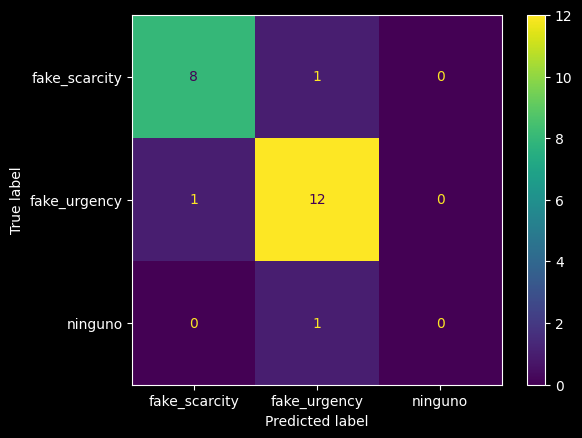

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

CSV_PATH = "datasets/unified_dataset.csv"

df = pd.read_csv(CSV_PATH)

# Limpieza mínima
df = df.dropna(subset=["type", "content", "source"])
df["type"] = df["type"].astype(str).str.strip()
df["content"] = df["content"].astype(str).str.strip()
df["source"] = df["source"].astype(str).str.strip()

X = df["content"]
y = df["type"]
groups = df["source"]

# --- Elegí UNA de estas dos estrategias de split ---

# (A) Split normal estratificado (más fácil, pero puede “memorizar” estilo de sitios)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),      # unigramas + bigramas
        min_df=2,                # ignora palabras ultra raras (ajustable)
        max_df=0.95,             # ignora palabras demasiado comunes
        strip_accents=None       # en español prefiero no tocar acentos
    )),
    ("clf", LinearSVC())
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

print("=== Classification report ===")
print(classification_report(y_test, pred, digits=3))

print("=== Confusion matrix ===")
labels = sorted(y.unique())
cm = confusion_matrix(y_test, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.show()


=== OOF Classification report (GroupKFold por source) ===
               precision    recall  f1-score   support

fake_scarcity      0.830     0.812     0.821        48
 fake_urgency      0.809     0.873     0.840        63
      ninguno      0.000     0.000     0.000         4

     accuracy                          0.817       115
    macro avg      0.546     0.562     0.554       115
 weighted avg      0.789     0.817     0.803       115



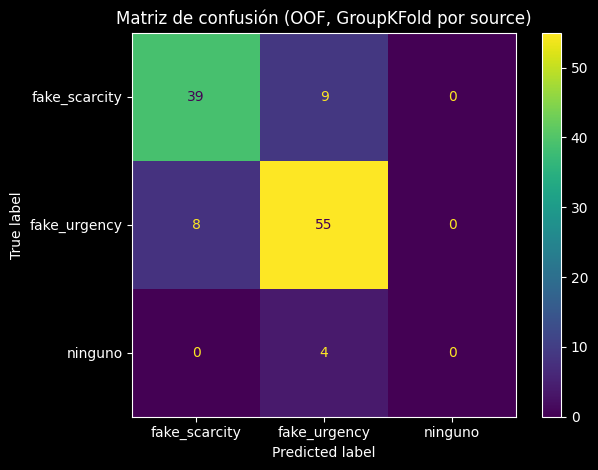

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

df = pd.read_csv("datasets/unified_dataset.csv").dropna(subset=["type", "content", "source"])
df["type"] = df["type"].astype(str).str.strip()
df["content"] = df["content"].astype(str).str.strip()
df["source"] = df["source"].astype(str).str.strip()

X = df["content"]
y = df["type"]
groups = df["source"]

labels = sorted(y.unique())

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 3),
        min_df=1,
        max_df=0.95
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

gkf = GroupKFold(n_splits=5)

# Predicciones out-of-fold (cada ejemplo se predice cuando su grupo está en test)
oof_pred = np.empty(len(df), dtype=object)

for train_idx, test_idx in gkf.split(X, y, groups):
    pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
    oof_pred[test_idx] = pipeline.predict(X.iloc[test_idx])

print("=== OOF Classification report (GroupKFold por source) ===")
print(classification_report(y, oof_pred, labels=labels, digits=3, zero_division=0))

cm = confusion_matrix(y, oof_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")  # números enteros
plt.title("Matriz de confusión (OOF, GroupKFold por source)")
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
df = pd.read_csv("datasets/unified_dataset.csv").dropna(subset=["type","content","source"])

df["binary"] = df["type"].apply(
    lambda x: "pattern" if x in ["fake_urgency","fake_scarcity"] else "ninguno"
)

X = df["content"]
y = df["binary"]
groups = df["source"]

pipeline_stage1 = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,3), min_df=1, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=3000, class_weight={"pattern": 1.0, "ninguno": 2.0}))
])

gkf = GroupKFold(n_splits=5)

oof_pred = np.empty(len(df), dtype=object)

for tr, te in gkf.split(X, y, groups):
    pipeline_stage1.fit(X.iloc[tr], y.iloc[tr])
    oof_pred[te] = pipeline_stage1.predict(X.iloc[te])

print("=== STAGE 1: pattern vs ninguno ===")
print(classification_report(y, oof_pred, digits=3))


df_p = df[df["type"] != "ninguno"]

X2 = df_p["content"]
y2 = df_p["type"]
groups2 = df_p["source"]


pipeline_stage2 = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,3),
        min_df=1,
        max_df=0.95
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

gkf = GroupKFold(n_splits=5)
oof_pred2 = np.empty(len(df_p), dtype=object)

for tr, te in gkf.split(X2, y2, groups2):
    pipeline_stage2.fit(X2.iloc[tr], y2.iloc[tr])
    oof_pred2[te] = pipeline_stage2.predict(X2.iloc[te])

print("=== STAGE 2: urgency vs scarcity ===")
print(classification_report(y2, oof_pred2, digits=3))



ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'pattern'